# Seklima data retrival with Frost API 

[Link to frost webpage](https://frost.met.no/index.html)

1. Create client id for yourself 
    * [Create client id here](https://frost.met.no/auth/requestCredentials.html)

2. Find weather elements you want to retrieve with:
    * [Weather element registrer](https://frost.met.no/elementtable)
    
3. Change station ID to get station coordinates
    * [stations](https://seklima.met.no/stations/)
    
More information: https://frost.met.no/python_example.html

In [1]:
# Import modules

import numpy as np
import pandas as pd

import requests

import matplotlib.pyplot as plt

from __future__ import print_function
from IPython.display import display, HTML

In [2]:
# Insert your own client ID here

client_id = 'insert client ID here'

# Insert station ID for the station retrieving data from

station_id = 'SN76956' # insert station ID, EX; 'SN76956' Goliat ,  'SN20926' hjelmsøybanken  ,   'SN76939' Valhall A

## Retrieve data from Frost API
This section gets the data from the Frost API service for seklima
- Change ref_time to time period you want data from
- Change data_to_retrieve with element IDs you want to retrieve, element IDs: [Weather element registrer](https://frost.met.no/elementtable)

Observations(Element IDs) and time available vary for each station, check this at [stations](https://seklima.met.no/stations/)

MAX 100.000 observations can be downloaded each run

In [8]:

#############################################

# Change ref_time to time period

ref_time = '2022-01-01/2023-01-01'


# fill this list with elements to retrieve according to frost API frost.met.no spesifications
# The elements in this scripts is examples 

data_to_retrieve = ['wind_speed'#,
                    #'wind_from_direction'#,
                    #'wind_speed_of_gust'
                    ]

#############################################



# Define endpoint and parameters

endpoint = 'https://frost.met.no/observations/v0.jsonld'
parameters = {
    'sources': f'{station_id}',
    'elements': ','.join(data_to_retrieve),
    'referencetime': f'{ref_time}',
}

# Issue an HTTP GET request
r = requests.get(endpoint, parameters, auth=(client_id,''))
# Extract JSON data
json = r.json()

# Check if the request worked, print out any errors
if r.status_code == 200:
    data = json['data']
    print('Data retrieved from frost.met.no!')
else:
    print('Error! Returned status code %s' % r.status_code)
    print('Message: %s' % json['error']['message'])
    print('Reason: %s' % json['error']['reason'])
    

Data retrieved from frost.met.no!


## Convert to dataframe
Convert the retrieved data into dataframes

In [4]:

# This will return a Dataframe with all of the observations in a table format
# This can take some minutes

df = pd.DataFrame()
for i in range(len(data)):
    row = pd.DataFrame(data[i]['observations'])
    row['referenceTime'] = data[i]['referenceTime']
    row['sourceId'] = data[i]['sourceId']
    df = pd.concat([df, row])

df = df.reset_index(drop=True)

display(df)

,elementId,value,unit,level,timeOffset,timeResolution,timeSeriesId,performanceCategory,exposureCategory,qualityCode,referenceTime,sourceId
0,wind_speed,9.8,m/s,"{'levelType': 'height_above_ground', 'unit': '...",PT0H,PT10M,0,C,2,0,2022-01-01T00:00:00.000Z,SN76956:0
1,wind_speed,10.3,m/s,"{'levelType': 'height_above_ground', 'unit': '...",PT0H,PT3H,0,C,2,0,2022-01-01T00:00:00.000Z,SN76956:0
2,wind_speed,9.9,m/s,"{'levelType': 'height_above_ground', 'unit': '...",PT0H,PT10M,0,C,2,0,2022-01-01T00:20:00.000Z,SN76956:0
3,wind_speed,10.8,m/s,"{'levelType': 'height_above_ground', 'unit': '...",PT20M,PT30M,0,C,2,2,2022-01-01T00:20:00.000Z,SN76956:0
4,wind_speed,14.5,m/s,"{'levelType': 'height_above_ground', 'unit': '...",PT0H,PT10M,0,C,2,0,2022-01-01T00:40:00.000Z,SN76956:0
...,...,...,...,...,...,...,...,...,...,...,...,...
44384,wind_speed,7.6,m/s,"{'levelType': 'height_above_ground', 'unit': '...",PT0H,PT10M,0,C,2,0,2022-12-31T23:00:00.000Z,SN76956:0
44385,wind_speed,7.1,m/s,"{'levelType': 'height_above_ground', 'unit': '...",PT0H,PT10M,0,C,2,0,2022-12-31T23:20:00.000Z,SN76956:0
44386,wind_speed,9.8,m/s,"{'levelType': 'height_above_ground', 'unit': '...",PT20M,PT30M,0,C,2,2,2022-12-31T23:20:00.000Z,SN76956:0
44387,wind_speed,5.6,m/s,"{'levelType': 'height_above_ground', 'unit': '...",PT0H,PT10M,0,C,2,0,2022-12-31T23:40:00.000Z,SN76956:0


Information about:
- PerformanceCategory, exposureCategory, qualityCode etc
(https://frost.met.no/dataclarifications.html)

In [9]:
""" 
Some datasets contains several different types of observations with the same elemntID. Sometimes observations have the same
"timeOffset" but different "timeResolution" and/or "timeOffset". 
TimeOffset can be modified in the "getting the data", but keys with a given name can also be removed manually. 
This shows how to remove rows with unwanted values.

If datafram contains all desired values, skip this!
"""


# Find outliers
unique_time_resolution = df['timeResolution'].unique()
unique_timeOffset = df['timeOffset'].unique()
unique_timeSeriesId = df['timeSeriesId'].unique()
unique_performanceCategory = df['performanceCategory'].unique()
unique_exposureCategory = df['exposureCategory'].unique()
unique_qualityCode = df['qualityCode'].unique()


 

print(unique_time_resolution)
print(unique_timeOffset)


 
# Example: remove all observations without 'timeresolution' = PT10M and 'timeOffset' = PT0H
# Keep what we want
df = df.loc[df['timeResolution'] == 'PT10M']
df = df.loc[df['timeOffset'] == 'PT0H']

display(df)

['PT10M' 'PT3H' 'PT30M']
['PT0H' 'PT20M']


,elementId,value,unit,level,timeOffset,timeResolution,timeSeriesId,performanceCategory,exposureCategory,qualityCode,referenceTime,sourceId
0,wind_speed,9.8,m/s,"{'levelType': 'height_above_ground', 'unit': '...",PT0H,PT10M,0,C,2,0,2022-01-01T00:00:00.000Z,SN76956:0
2,wind_speed,9.9,m/s,"{'levelType': 'height_above_ground', 'unit': '...",PT0H,PT10M,0,C,2,0,2022-01-01T00:20:00.000Z,SN76956:0
4,wind_speed,14.5,m/s,"{'levelType': 'height_above_ground', 'unit': '...",PT0H,PT10M,0,C,2,0,2022-01-01T00:40:00.000Z,SN76956:0
6,wind_speed,10.5,m/s,"{'levelType': 'height_above_ground', 'unit': '...",PT0H,PT10M,0,C,2,0,2022-01-01T01:00:00.000Z,SN76956:0
7,wind_speed,10.8,m/s,"{'levelType': 'height_above_ground', 'unit': '...",PT0H,PT10M,0,C,2,0,2022-01-01T01:20:00.000Z,SN76956:0
...,...,...,...,...,...,...,...,...,...,...,...,...
44380,wind_speed,7.1,m/s,"{'levelType': 'height_above_ground', 'unit': '...",PT0H,PT10M,0,C,2,0,2022-12-31T22:20:00.000Z,SN76956:0
44382,wind_speed,5.8,m/s,"{'levelType': 'height_above_ground', 'unit': '...",PT0H,PT10M,0,C,2,0,2022-12-31T22:40:00.000Z,SN76956:0
44384,wind_speed,7.6,m/s,"{'levelType': 'height_above_ground', 'unit': '...",PT0H,PT10M,0,C,2,0,2022-12-31T23:00:00.000Z,SN76956:0
44385,wind_speed,7.1,m/s,"{'levelType': 'height_above_ground', 'unit': '...",PT0H,PT10M,0,C,2,0,2022-12-31T23:20:00.000Z,SN76956:0


In [10]:
"""
Simplify the dataframe 
"""

# keep these columns
columns = ['referenceTime','elementId', 'value']
df2 = df[columns].copy()


# Convert the time value to something Python understands
df2['referenceTime'] = pd.to_datetime(df2['referenceTime'])

# Pivot the DataFrame to have 'elementId' as columns and 'referenceTime' as index
df3 = df2.pivot_table(index='referenceTime', columns='elementId', values='value')

# Rename the index label
df3 = df3.rename_axis(['time'])

display(df3)

elementId,wind_speed
time,
2022-01-01 00:00:00+00:00,9.8
2022-01-01 00:20:00+00:00,9.9
2022-01-01 00:40:00+00:00,14.5
2022-01-01 01:00:00+00:00,10.5
2022-01-01 01:20:00+00:00,10.8
...,...
2022-12-31 22:20:00+00:00,7.1
2022-12-31 22:40:00+00:00,5.8
2022-12-31 23:00:00+00:00,7.6


## Save dataframe as NC-file
Define a function that saves the dataframe as an nc-file. 
- Change the output_filename to desired new saved filename

Filesize for time and wind speed (timeresolution: every 20 min) for 12 months: 411 KB

In [11]:
"""
This code makes a new optional directory at a desired location and saves the new file in this new directory.
If the directory already exist it will just save the new file in that directory. This way different ncfiles can be saved
in the same directory by keeping the same directory name and changing only the output_filename
"""

import xarray as xr
import os

#######################################

# New directory 
directory = "weather_data"
  
# Parent Directory path 
parent_dir = "C:/Users/Ida/" # Change path 

# Filename new ncfile
output_filename = f'seklima_weather_data_stations_{station_id}_2022' # Choose filename

########################################


# Path 
path = os.path.join(parent_dir, directory) 
  
# Create the directory if not already existing
if not os.path.isdir(path):
    os.mkdir(path)


def save_dataframe_to_netcdf(dataframe, output_file):
    dataset = xr.Dataset(data_vars=dataframe.to_dict('series'))
    output_path = f"{parent_dir}{directory}/{output_file}"
    dataset.to_netcdf(output_path)

    print(f"Data saved successfully to {output_path}.")


save_dataframe_to_netcdf(df3, output_filename)

Data saved successfully to C:/Users/Ida/weather_data/seklima_weather_data_stations_SN76956_2022.


## How to use the new ncfile

In [12]:

import netCDF4 as nc

filename = 'C:/Users/Ida/weather_data/seklima_weather_data_stations_SN76956_2022'
ncfile = nc.Dataset(filename)

# print variables in the file
for variable in ncfile.variables:
    print(variable)


time
wind_speed


In [13]:
# convert timestamps into nice readable dates

import datetime as dt
from datetime import date, timedelta

time = ncfile.variables["time"][:]

ts = np.linspace(0,len(time)-1,len(time))

nice_time = []

for i in range(0,len(ts)):
    t = dt.datetime.utcfromtimestamp(time[i]/10**9)
    nice_time.append(t)
    

In [14]:
# Extract variable
wind_speed = ncfile.variables["wind_speed"][:]


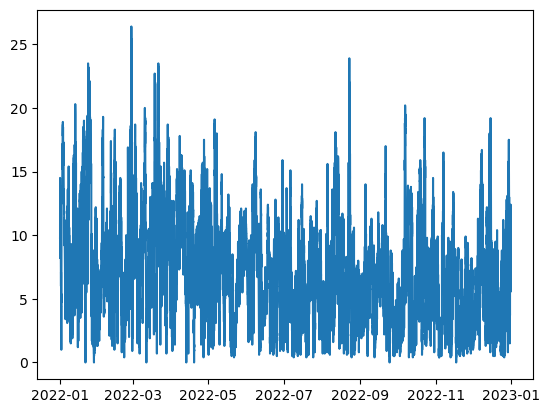

In [15]:
# Simple plot

plt.plot(nice_time, wind_speed)